<a href="https://colab.research.google.com/github/MichaelTj02/FinalProject_Group1/blob/main/CombinedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from ultralytics import YOLO
import cv2

In [ ]:
# Function to capture license plate within the rider bounding box (for cases where there are multiple riders)
def is_within_bbox(inner_bbox, outer_bbox):
    x1, y1, x2, y2 = inner_bbox
    X1, Y1, X2, Y2 = outer_bbox
    return X1 <= x1 <= X2 and X1 <= x2 <= X2 and Y1 <= y1 <= Y2 and Y1 <= y2 <= Y2

# Combined model

In [2]:
# Load YOLOv8 models
helmet_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_MotorcycleModel\weights\best.pt")
plate_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_LicensePlateModel\weights\best.pt")

In [6]:
# Load the image
image = cv2.imread(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new106.jpg")

In [7]:
# Run the first YOLO model for helmet and rider detection
results = helmet_model(image, save=True)


0: 640x640 1 without helmet, 1 rider, 1 number plate, 35.6ms
Speed: 4.1ms preprocess, 35.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\mtj02\runs\detect\predict5


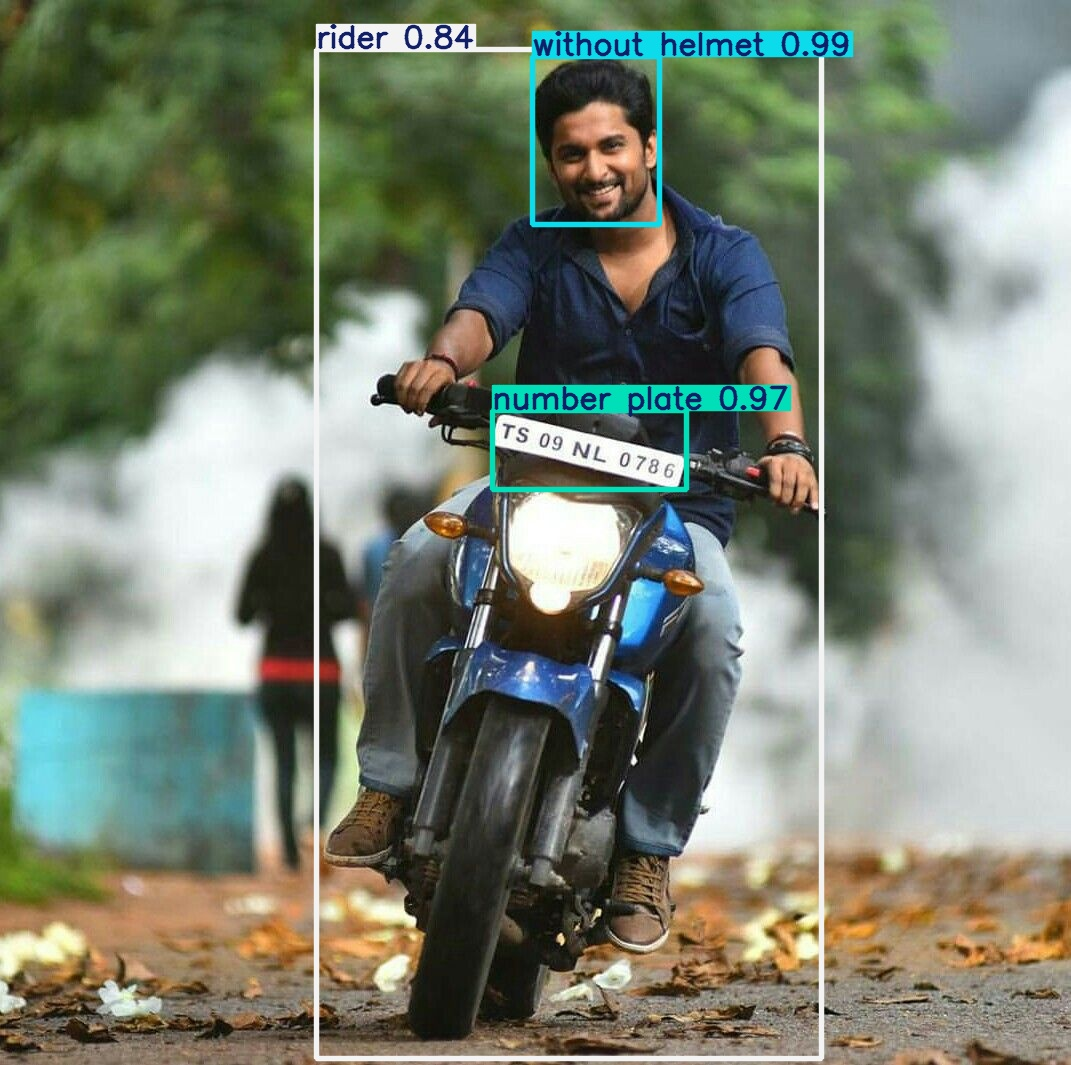

In [8]:
# Helmet model prediction
%matplotlib inline
from PIL import Image

Image.open(r"C:\Users\mtj02\runs\detect\predict5\image0.jpg")

In [11]:
# Iterate through detections
for result in results[0].boxes.data.tolist():  # Extract detected bounding boxes
    x1, y1, x2, y2, confidence, class_id = result[:6]
    class_name = helmet_model.names[int(class_id)]  # Map class ID to label

    if class_name == "rider":
        rider_bbox = [x1, y1, x2, y2]

        # Check for a helmet in the rider's bounding box
        helmet_present = any(
            box for box in results[0].boxes.data.tolist()
            if helmet_model.names[int(box[5])] == "helmet" and is_within_bbox(box[:4], rider_bbox)
        )
        if helmet_present:
            continue  # Skip if the rider has a helmet

        # Check for a license plate in the rider's bounding box
        license_plate = next(
            (
                box for box in results[0].boxes.data.tolist()
                if helmet_model.names[int(box[5])] == "number plate" and is_within_bbox(box[:4], rider_bbox)
            ),
            None,
        )

In [12]:
from operator import itemgetter

# Step 5: Crop License Plate and Process with the Second Model
if license_plate:
    # Crop license plate from the image
    plate_x1, plate_y1, plate_x2, plate_y2 = map(int, plate_bbox)
    cropped_plate = image[plate_y1:plate_y2, plate_x1:plate_x2]

    # Run the second YOLO model for character recognition
    plate_results = plate_model(cropped_plate)

    # Extract detected characters and their bounding boxes
    detected_chars = [
        {
            "char": plate_model.names[int(box[5])],  # Character label
            "bbox": box[:4],  # Bounding box of the character
        }
        for box in plate_results[0].boxes.data.tolist()
    ]

    # Sort characters first by y-coordinate, then by x-coordinate for each row
    sorted_chars = sorted(
        detected_chars,
        key=lambda c: (c["bbox"][1], c["bbox"][0])  # Sort by top (y1), then left (x1)
    )

    # Concatenate characters to form the license plate text
    license_plate_text = "".join(char["char"] for char in sorted_chars)

    # Output the result
    print(f"Rider without helmet. License plate text: {license_plate_text}")
else:
    print("Rider without helmet, but no license plate detected.")



0: 288x640 1 L, 1 M, 1 T, 2 0s, 1 6, 1 7, 1 8, 1 9, 18.4ms
Speed: 3.2ms preprocess, 18.4ms inference, 3.7ms postprocess per image at shape (1, 3, 288, 640)
Rider without helmet. License plate text: T09ML0786
